## Robot navigation 

**This file gives a simple robot navigation case study**

### Initialize the Robot Dynamics

In [1]:
# load dynamics

import polytope as pc
import numpy as np
from best.logic.translate import formula_to_pomdp
from best.abstraction.gridding import LTIGrid

import polytope as pc
import numpy as np
import math
from collections import OrderedDict

import matplotlib.patches
import matplotlib.pyplot as plt
from matplotlib import patches

from best.models.lti import LTI, LTIGaussian
from best.models.pomdp import POMDP, POMDPNetwork
from best.abstraction.gridding import LTIGrid
from Demos.Robot_navigation import specify_robot
from Controller.Specifications import Fsa
from best.models.pomdp_sparse_utils import diagonal, get_T_uxXz
from best.solvers.occupation_lp import solve_ltl


print('Load robot model: Simple integrator model')
# Define the linear time invariant system
# A = np.array([[0,-0.8572],[0.1,0.5]])
dim = 2
A = np.eye(2)  # np.array([[.9,-0.32],[0.1,0.9]])
B = np.eye(dim)  # array([[1], [0.1]])
W = np.array([[0.1, 0], [0, 0.1]])  # 2*Tr.dot(np.eye(dim)).dot(Tr)  # noise on transitions

# Accuracy
C = np.array([[1, 0], [0, 1]])  # defines metric for error (||y_finite-y||< epsilon with y= cx   )

sys_lti = LTI(A, B, C, None, W=W)  # LTI system with   D = None

sys_lti.setU(pc.box2poly(np.kron(np.ones((sys_lti.m, 1)), np.array([[-1, 1]]))))  # continuous set of inputs
sys_lti.setX(pc.box2poly(np.kron(np.ones((sys_lti.dim, 1)), np.array([[-10, 10]]))))  # X space

 
 
# specify required behaviour
formula, regions = specify_robot()  # type: dict


Load robot model: Simple integrator model


-------Grid the robots state space------
A = [[1. 0.]
 [0. 1.]]
 , B =[[1. 0.]
 [0. 1.]]
 , C = [[1 0]
 [0 1]]
 , D = None
 , W = [[0.1 0. ]
 [0.  0.1]]
Single polytope 
  [[ 1.  0.] |    [[10.]
   [ 0.  1.] x <=  [10.]
   [-1. -0.] |     [10.]
   [-0. -1.]]|     [10.]]

status: optimal
optimal epsilon 1.0000720579253304
optimal M [[ 1.00008 -0.     ]
 [-0.       1.00008]]
Optimal K [[-0.99984 -0.     ]
 [-0.      -0.99984]]
MDP: (9,) inputs ('u_d',) --> 813 states s --> 813 outputs (s,xc)
before prune: nnz: 1754060, sparsity: 0.2948633832381784
after prune: nnz: 151225, sparsity: 0.025421430926076377


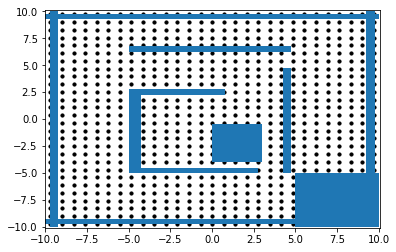

In [2]:
### Grid Robot


print("-------Grid the robots state space------")
#  set the state spaces: 
d_opt = np.array([[0.69294], [0.721]]) # tuned gridding ratio from a previous paper
d =  d_opt  # with distance measure 0.6=default
un = 3



from collections.abc import Iterable

print(sys_lti)
print(sys_lti.X)
lti_n = sys_lti.normalize()

abstr = LTIGrid(lti_n, d.flatten(), un=3 )
fig = plt.figure()
ax0 = fig.add_subplot(111)
abstr.plot(ax0)

# plot regions
for _, poly_set in regions.items():

   for index in range(len(poly_set)):
       
        V = pc.extreme(poly_set[index])
        ax0.add_patch(patches.Polygon(V))
        
print (abstr.mdp)
print ('before prune: nnz: {}, sparsity: {}'.format(abstr.mdp.nnz, abstr.mdp.sparsity))
abstr.mdp.prune(1e-6)
print ('after prune: nnz: {}, sparsity: {}'.format(abstr.mdp.nnz, abstr.mdp.sparsity))



In [3]:
%debug

 

ERROR:root:No traceback has been produced, nothing to debug.


### Specify the required behaviour

In [4]:
fsaform = Fsa() # this is a FSA , contains a digraph
fsaform.from_formula(formula) # given a more complex formula

print("The synthesised formula is:",formula)
print("The FSA is :", fsaform)

dfsa, dfsa_init, dfsa_final = formula_to_pomdp(formula)
print(dfsa)

network = POMDPNetwork([abstr.mdp, dfsa])


The synthesised formula is: ( ( ( !obst & !col ) U pac ) & ( !obst U col ) )
The FSA is : 
g=, 
init={'0': 1}, 
final={'1'}, 
props={'col': 1, 'obst': 2, 'pac': 4}, 
alphabet={0, 1, 2, 3, 4, 5, 6, 7}
 FSA with : _node={'2': {}, '1': {}, '0': {}}, 
 FSA with : _succ={'2': {'1': {'weight': 0, 'input': {1, 3, 5, 7}, 'guard': '((!pac & col) | (pac & col))', 'label': '((!pac & col) | (pac & col))'}, '2': {'weight': 0, 'input': {0, 4}, 'guard': '(!col & !obst)', 'label': '(!col & !obst)'}}, '1': {'1': {'weight': 0, 'input': {0, 1, 2, 3, 4, 5, 6, 7}, 'guard': '(1)', 'label': '(1)'}}, '0': {'0': {'weight': 0, 'input': {0}, 'guard': '(!pac & (!col & !obst))', 'label': '(!pac & (!col & !obst))'}, '1': {'weight': 0, 'input': {5, 7}, 'guard': '(pac & col)', 'label': '(pac & col)'}, '2': {'weight': 0, 'input': {4}, 'guard': '(pac & (!col & !obst))', 'label': '(pac & (!col & !obst))'}}}
MDP: (2, 2, 2) inputs ('pac', 'obst', 'col') --> 4 states mu --> 4 outputs mu


In [5]:
print(network)


MDP network: (9, 2, 2, 2) inputs ('u_d', 'pac', 'obst', 'col'), (813, 4) states ('s', 'mu'), (813, 4) outputs ('(s,xc)', 'mu')


In [6]:
import copy
props={'col': 1, 'pac': 2, 'obst': 4}

s = 0

 
for key in props:
    print(key)
    length = len(regions[key])
    if length >1:
        network.add_connection(['(s,xc)'], key,
                                       lambda s_xc: max(*[abstr.polytopic_predicate(s_xc[1], regions[key][l])
                                                          for l in range(length)]))
    else:
        network.add_connection(['(s,xc)'], key,
                               lambda s_xc: abstr.polytopic_predicate(s_xc[1], regions[key][0]) )
 
 

col
pac
obst


In [7]:
Robotmdp = diagonal(get_T_uxXz(network.pomdps['s']), 2, 3)

import itertools
stacked =  [np.array(network.pomdps['mu'].T((col,pac,obs)).todense())
               for col,pac,obs in itertools.product([0,1],[0,1],[0,1])]
Robotdfa = np.stack(stacked    ,axis=0)

In [8]:
# take min col network.connections[0]
# take min pac network.connections[1]
# take max obstacle  network.connections[2]
# print(np.int_(network.connections[0][2][0]))
strat = 4 * (1-np.int_(network.connections[0][2][0]))\
        + 2 * (1-np.int_(network.connections[1][2][0])) \
        +  1 * (np.int_(network.connections[2][2][1])) 

 
delta = 0.01


In [ ]:
# reach_prob, val2 = solve_delta(Robotmdp, Robotdfa, conn, delta, s0=0, q0=0, q_target=1)

# strat = np.array([[0] * (Robotmdp.shape[2]), [1] * (Robotmdp.shape[2])]).transpose()
strat = strat.transpose()
s_list = abstr.x_to_all_s(np.array([[-9],[-9]]))

print(s_list)
model,reach_prob = solve_ltl(Robotmdp, Robotdfa, strat,0, s0=max(s_list), q0=0, q_target=1)

 




[0, 1, 2, 56, 57, 58, 28, 29, 30]
Academic license - for non-commercial use only
create empty model 0.020541906356811523
added variables 236.92221903800964


In [ ]:
import scipy.sparse
import matplotlib.pyplot as plt

m = scipy.sparse.coo_matrix((reach_prob['x'],
                             (np.array(reach_prob['indices'])[::,1],
                              np.array(reach_prob['indices'])[::,2])))
Pol = m.argmax(1)
Z = m.sum(1)

Z = Z[:-1:].reshape(abstr.n_list[0],abstr.n_list[1])
Pol = Pol[:-1:].reshape(abstr.n_list[0],abstr.n_list[1])


fig, (ax0, ax1) = plt.subplots(2, 1)
# plt.show()


ax0.pcolorfast((-10,10),(-10,10),np.array(Pol))
ax1.pcolorfast((-10,10),(-10,10),np.array(Z))
plt.show()
 
 

In [ ]:
import scipy.sparse
import matplotlib.pyplot as plt

q = 0
bol_mask = reach_prob['indices'][::,0]==0
m = scipy.sparse.coo_matrix((reach_prob['x'][bol_mask],
                             (np.array(reach_prob['indices'])[::,1][bol_mask],
                              np.array(reach_prob['indices'])[::,2][bol_mask])))
print(m)

In [ ]:
Pol = np.array(m.argmax(1))
Z = m.sum(1)

Z = Z[:-1:].reshape(abstr.n_list[0],abstr.n_list[1])
# Pol = Pol[:-1:].reshape(abstr.n_list[0],abstr.n_list[1])
print('max Z', np.max(Z))



# fig, (ax0, ax1) = plt.subplots(2, 1)



ax0  = plt.axes()
# plt.show()
xy = np.array([[abstr.s_to_x(s)[0],abstr.s_to_x(s)[1]] for s in range(abstr.n_list[0]*(abstr.n_list[1])) ] )
print(xy)
x= xy[::,0]
y= xy[::,1]
print(abstr.ud_to_u(0)[0])
print('test',np.concatenate([[abstr.ud_to_u(p)] for p in range(9) ]))
dxy =np.concatenate([[[abstr.ud_to_u(p[0])]] for p in Pol ] )
print(Pol.shape)

print('test', dxy[::,0])
plt.arrow(x, y, dxy[::,0], dxy[::,0])
# ax1.pcolorfast((-10,10),(-10,10),np.array(Pol))
ax0.pcolorfast((-10,10),(-10,10),np.array(Z))

plt.show()


In [4]:

json.dump({'s':1,'c':1}, file)